In [1]:
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [2]:
register_df = pd.read_csv("/net/scratch/jmoehring/tiles_register_biome_bin.csv")

In [3]:
register_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1215181 entries, 0 to 1215180
Data columns (total 8 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   base_file_name  1215181 non-null  object 
 1   file_path       1215181 non-null  object 
 2   resolution      1215181 non-null  float64
 3   x               1215181 non-null  int64  
 4   y               1215181 non-null  int64  
 5   label_quality   1193120 non-null  float64
 6   biome           1215181 non-null  float64
 7   resolution_bin  1215181 non-null  float64
dtypes: float64(4), int64(2), object(2)
memory usage: 74.2+ MB


In [23]:
images_df = register_df.groupby("base_file_name").min("resolution_bin").reset_index()

In [155]:
register_df[register_df["file_path"].str.contains("13905_8833.tif")]

,base_file_name,file_path,resolution,x,y,label_quality,biome,resolution_bin
317072,uavforsat_2017_CFB036_ortho.tif,/net/scratch/jmoehring/tiles/uavforsat_2017_CF...,0.009,13905,8833,3.0,4.0,0.0


<Axes: >

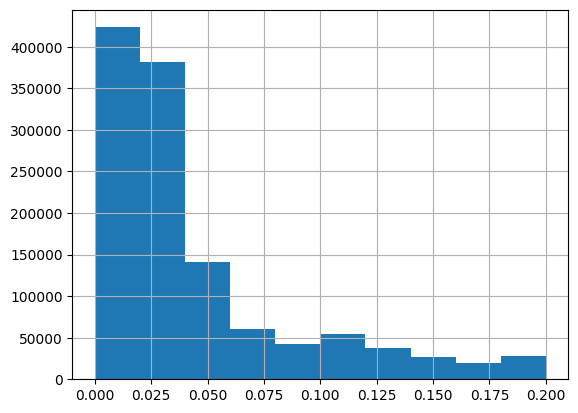

In [8]:
register_df["resolution_bin"].hist()

In [33]:
register_df["resolution_bin_str"].nunique()

11

In [148]:
# Calculate the value counts
value_counts = register_df["resolution_bin"].value_counts()

# Calculate the square root of the counts
sqrt_counts = value_counts.apply(lambda x: x**0.6)

# get the inverse of the square root
class_weights = 1 / sqrt_counts

<Axes: >

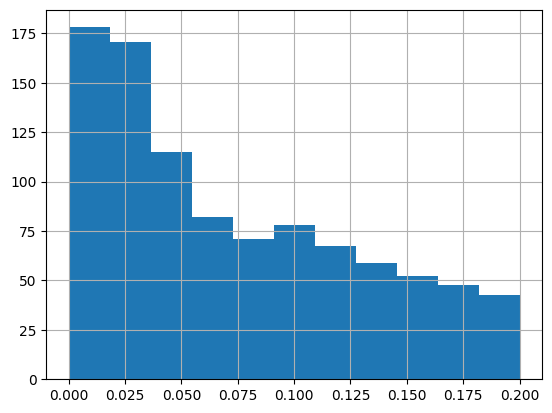

In [149]:
# plot hisogram with value counts multiplied by the class weights
(
    register_df["resolution_bin"].hist(
        weights=register_df["resolution_bin"].map(class_weights), bins=11
    )
)

In [125]:
sample_weights = train_register["resolution_bin"].map(class_weights)

In [122]:
normalized_counts

resolution_bin
0.00    0.028135
0.02    0.029635
0.04    0.048648
0.06    0.074234
0.10    0.078598
0.08    0.089219
0.12    0.094913
0.14    0.112642
0.16    0.129759
0.18    0.146945
0.20    0.167271
Name: count, dtype: float64

<Axes: xlabel='resolution_bin'>

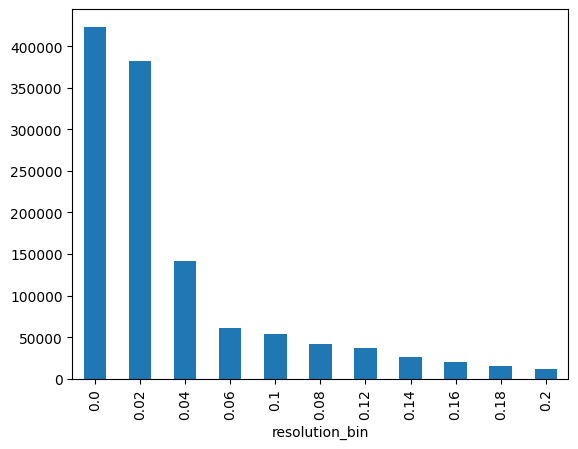

In [55]:
register_df["resolution_bin"].value_counts().plot(kind="bar")

<Axes: xlabel='resolution_bin'>

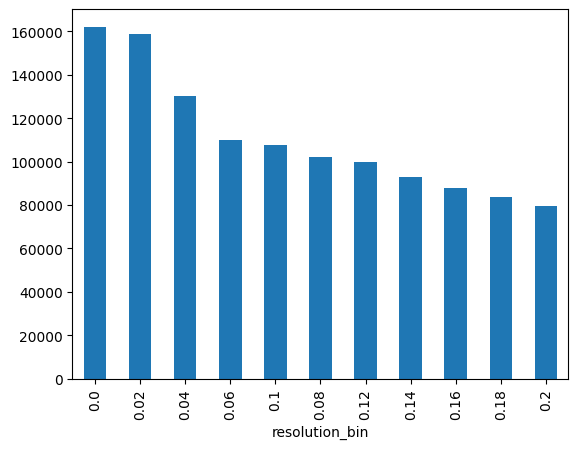

In [56]:
rounded_inverse_counts.plot(kind="bar")

In [104]:
from sklearn.model_selection import StratifiedKFold

base_file_register = (
    register_df.groupby("base_file_name")
    .agg({"resolution_bin": "min", "biome": "first"})
    .reset_index()
)
kfold = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

# get the train and test file register of the first fold
train_index, test_index = list(
    kfold.split(base_file_register, base_file_register[["biome"]].astype(str))
)[0]
train_files = base_file_register.iloc[train_index]
test_files = base_file_register.iloc[test_index]

train_register = register_df[
    register_df["base_file_name"].isin(train_files["base_file_name"])
]
test_register = register_df[
    register_df["base_file_name"].isin(test_files["base_file_name"])
]

/net/home/jmoehring/.conda/envs/standing-deadwood-env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


In [101]:
base_file_register.head()

,base_file_name,resolution_bin,biome
0,20191016_FVA_Walddrohnen_Totholz_8_ortho.tif,0.02,4.0
1,20191024_FVA_Walddrohnen_Totholz_7_ortho.tif,0.02,4.0
2,20200720_FVA_Walddrohnen_Totholz_6_ortho.tif,0.00,4.0
3,20210727_FVA_Walddrohnen_Totholz_5_ortho.tif,0.00,4.0
4,20211001_FVA_Walddrohnen_Totholz_3_ortho.tif,0.02,4.0


<Axes: >

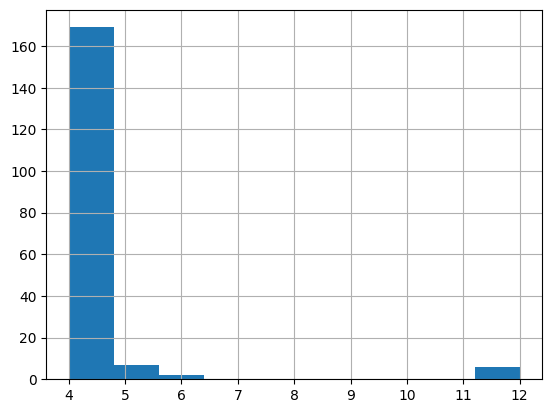

In [102]:
train_files["biome"].hist()

<Axes: >

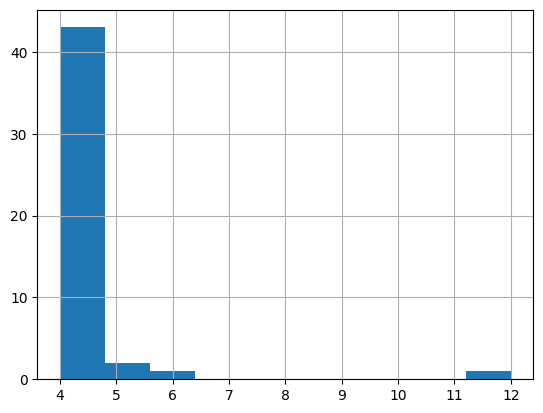

In [103]:
test_files["biome"].hist()

In [4]:
import wandb
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
run_id = "garg20i1"
api = wandb.Api()
experiment = api.run(f"jmoehring/standing-deadwood-unet-pro/{run_id}")

In [6]:
fold = 0
epoch = 19

In [7]:
eval_df_1 = pd.read_csv(
    f"/net/scratch/jmoehring/eval_{experiment.name}_fold_{0}_epoch_{19}.csv"
)

In [8]:
eval_df_2 = pd.read_csv(
    f"/net/scratch/jmoehring/eval_{experiment.name}_fold_{1}_epoch_{12}.csv"
)

In [9]:
eval_df_3 = pd.read_csv(
    f"/net/scratch/jmoehring/eval_{experiment.name}_fold_{2}_epoch_{20}.csv"
)

In [10]:
# union of the two dataframes
eval_df = pd.concat([eval_df_1, eval_df_2, eval_df_3])

In [15]:
eval_df = pd.read_csv(
    f"/net/scratch/jmoehring/eval_100k_samples_biome_stratified_onefold_val_fold_0_epoch_20.csv"
)

In [11]:
# add new column biome names
biome_names = {
    4: "Temperate Broadleaf and Mixed Forests",
    5: "Temperate Coniferous Forests",
    6: "Boreal Forests/Taiga",
    12: "Mediteranean Forests",
}
eval_df["biome_name"] = eval_df["biome"].map(biome_names)

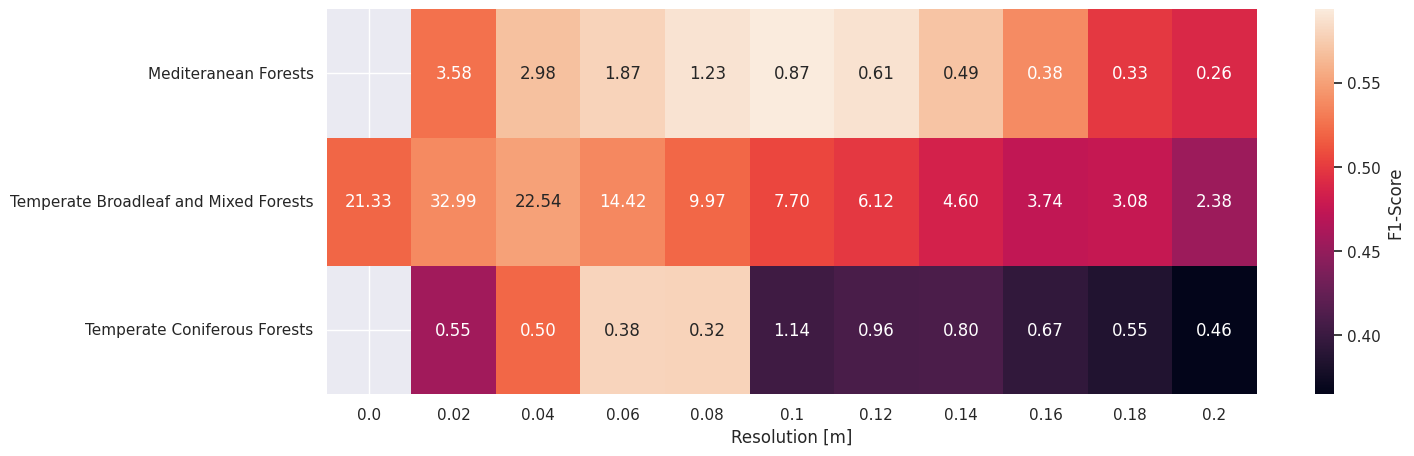

In [21]:
sns.set_theme()
pivoted = eval_df.pivot_table(index="biome_name", columns="resolution_bin", values="f1")
pivoted_labels = (
    eval_df.pivot_table(
        index="biome_name",
        columns="resolution_bin",
        values="f1",
        aggfunc="count",
    )
    / 1000
)
ax = sns.heatmap(
    pivoted,
    cmap="rocket",
    annot=pivoted_labels,
    fmt=".2f",
    cbar_kws={"label": "F1-Score"},
)
ax.set_ylabel("")
ax.set_xlabel("Resolution [m]")
fig = ax.get_figure()
fig.set_size_inches(15, 5)
plt.show()

In [22]:
fig.tight_layout().savefig(
    "f1_score_heatmap.png",
    dpi=800,
)

In [25]:
eval_df["biome"].value_counts()

biome
4.0     633830
12.0     49894
5.0      20321
Name: count, dtype: int64

In [26]:
images_df = register_df.groupby("base_file_name").min("resolution_bin").reset_index()